In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [5]:
df = pd.read_csv("/kaggle/input/feature/Energy_consumption.csv")


In [6]:
print(df.shape)
print(df.info())
print(df.head())


(1000, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Timestamp          1000 non-null   object 
 1   Temperature        1000 non-null   float64
 2   Humidity           1000 non-null   float64
 3   SquareFootage      1000 non-null   float64
 4   Occupancy          1000 non-null   int64  
 5   HVACUsage          1000 non-null   object 
 6   LightingUsage      1000 non-null   object 
 7   RenewableEnergy    1000 non-null   float64
 8   DayOfWeek          1000 non-null   object 
 9   Holiday            1000 non-null   object 
 10  EnergyConsumption  1000 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 86.1+ KB
None
             Timestamp  Temperature   Humidity  SquareFootage  Occupancy  \
0  2022-01-01 00:00:00    25.139433  43.431581    1565.693999          5   
1  2022-01-01 01:00:00    27.731651  54

SEPARATE FEATURES & TARGET

In [20]:
X = df.drop('EnergyConsumption', axis=1)
y = df['EnergyConsumption']

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (1000, 14)
Target shape: (1000,)


Separate numeric and categorical columns

In [22]:

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include='object').columns

print("Numeric columns:", list(num_cols))
print("Categorical columns:", list(cat_cols))


Numeric columns: ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'is_weekend']
Categorical columns: ['HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday']


Handle Missing Values

In [24]:

X[num_cols] = X[num_cols].fillna(X[num_cols].median())


X[cat_cols] = X[cat_cols].fillna(X[cat_cols].mode().iloc[0])

print("Missing values after handling:", X.isnull().sum().sum())


Missing values after handling: 0


Convert On/Off → 1/0                                                                                          Binary Encoding (Label Encoding for binary categorical variables).

In [25]:
for col in cat_cols:
    if set(X[col].unique()) <= {'On', 'Off'}:
        X[col] = X[col].map({'Off': 0, 'On': 1})

print(X.head())


                     Temperature   Humidity  SquareFootage  Occupancy  \
Timestamp                                                               
2022-01-01 00:00:00    25.139433  43.431581    1565.693999          5   
2022-01-01 01:00:00    27.731651  54.225919    1411.064918          1   
2022-01-01 02:00:00    28.704277  58.907658    1755.715009          2   
2022-01-01 03:00:00    20.080469  50.371637    1452.316318          1   
2022-01-01 04:00:00    23.097359  51.401421    1094.130359          9   

                     HVACUsage  LightingUsage  RenewableEnergy  DayOfWeek  \
Timestamp                                                                   
2022-01-01 00:00:00          1              0         2.774699     Monday   
2022-01-01 01:00:00          1              1        21.831384   Saturday   
2022-01-01 02:00:00          0              0         6.764672     Sunday   
2022-01-01 03:00:00          0              1         8.623447  Wednesday   
2022-01-01 04:00:00       

Term	Meaning
Time Series Sorting

In [7]:
df = df.sort_index()
print("Data sorted by timestamp index")
print("First index:", df.index.min())
print("Last index:", df.index.max())


Data sorted by timestamp index
First index: 0
Last index: 999


In [8]:
print("Duplicate timestamps:", df.index.duplicated().sum())
df = df[~df.index.duplicated()]


Duplicate timestamps: 0


In [9]:
print("\nMissing values per column:")
print(df.isnull().sum())



Missing values per column:
Timestamp            0
Temperature          0
Humidity             0
SquareFootage        0
Occupancy            0
HVACUsage            0
LightingUsage        0
RenewableEnergy      0
DayOfWeek            0
Holiday              0
EnergyConsumption    0
dtype: int64


CHECK IF TIMESTAMP COLUMN EXISTS

In [14]:
print(df.columns)


Index(['Timestamp', 'Temperature', 'Humidity', 'SquareFootage', 'Occupancy',
       'HVACUsage', 'LightingUsage', 'RenewableEnergy', 'DayOfWeek', 'Holiday',
       'EnergyConsumption'],
      dtype='object')


CONVERT TIMESTAMP COLUMN TO DATETIME

In [15]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
print(df['Timestamp'].dtype)


datetime64[ns]


SET IT AS INDEX

In [17]:
df = df.set_index('Timestamp')
print(type(df.index))


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [18]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

print(df[['year', 'month', 'day', 'dayofweek', 'is_weekend']].head())


                     year  month  day  dayofweek  is_weekend
Timestamp                                                   
2022-01-01 00:00:00  2022      1    1          5           1
2022-01-01 01:00:00  2022      1    1          5           1
2022-01-01 02:00:00  2022      1    1          5           1
2022-01-01 03:00:00  2022      1    1          5           1
2022-01-01 04:00:00  2022      1    1          5           1


In [22]:
df['Energy_lag_1'] = df['EnergyConsumption'].shift(1)
df['Energy_lag_7'] = df['EnergyConsumption'].shift(7)

print(df[['EnergyConsumption', 'Energy_lag_1', 'Energy_lag_7']].head(10))


                     EnergyConsumption  Energy_lag_1  Energy_lag_7
Timestamp                                                         
2022-01-01 00:00:00          75.364373           NaN           NaN
2022-01-01 01:00:00          83.401855     75.364373           NaN
2022-01-01 02:00:00          78.270888     83.401855           NaN
2022-01-01 03:00:00          56.519850     78.270888           NaN
2022-01-01 04:00:00          70.811732     56.519850           NaN
2022-01-01 05:00:00          84.321885     70.811732           NaN
2022-01-01 06:00:00          76.165791     84.321885           NaN
2022-01-01 07:00:00          74.131906     76.165791     75.364373
2022-01-01 08:00:00          78.206236     74.131906     83.401855
2022-01-01 09:00:00          77.992214     78.206236     78.270888


In [23]:
df['Energy_roll_mean_7'] = df['EnergyConsumption'].rolling(7).mean()
df['Energy_roll_std_7'] = df['EnergyConsumption'].rolling(7).std()

print(df[['Energy_roll_mean_7', 'Energy_roll_std_7']].head(10))


                     Energy_roll_mean_7  Energy_roll_std_7
Timestamp                                                 
2022-01-01 00:00:00                 NaN                NaN
2022-01-01 01:00:00                 NaN                NaN
2022-01-01 02:00:00                 NaN                NaN
2022-01-01 03:00:00                 NaN                NaN
2022-01-01 04:00:00                 NaN                NaN
2022-01-01 05:00:00                 NaN                NaN
2022-01-01 06:00:00           74.979482           9.387348
2022-01-01 07:00:00           74.803415           9.390483
2022-01-01 08:00:00           74.061184           8.783287
2022-01-01 09:00:00           74.021374           8.761631


In [24]:
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower, upper)

print("Outliers capped using IQR")


Outliers capped using IQR


In [25]:
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print("After encoding shape:", df.shape)


After encoding shape: (1000, 24)


In [26]:
before = df.shape[0]
df = df.dropna()
after = df.shape[0]

print(f"Rows removed due to lag features: {before - after}")
print("Final shape:", df.shape)


Rows removed due to lag features: 7
Final shape: (993, 24)


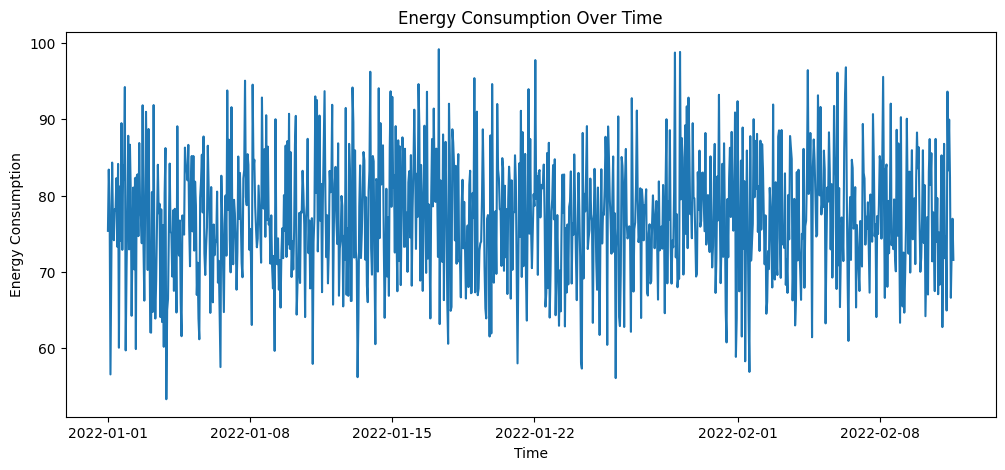

In [19]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['EnergyConsumption'])
plt.title("Energy Consumption Over Time")
plt.xlabel("Time")
plt.ylabel("Energy Consumption")
plt.show()
